### How do models augmented with different types of data compare?

We compare the following models:

- M: not augmented
- M_CAD: augmented with manual CAD
- M_aCAD: augmented with automated CAD from polyjuice 
- M_aCAD_gpt: augmented with adversarial examples

What are the labels of the augmented data? For those where there is no ground truth, use heuristics

#### Usecases

Sexism and hate speech because the ude of identity terms there is especially noteworthy.

#### Datasets

- training:
- test: in-domain, out-of-domain, Hatecheck

#### Models

Logreg, DistilBERT

#### Metrics

F1, FPR, and others in https://arxiv.org/pdf/2203.09192.pdf

### Experimental Setup

- train 100 models of each type with different train-test splits, alwasy test on OOD and HC
- train 100 models, but keep the 'base' data in all different models consistent

### todo: 
- ~~model trained on CAD from all sources~~

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# DESIGNEDDATAPATH = '../designed_data/cad/'

In [2]:
constructs = ['hatespeech']
construct_names = [
    'hatespeech',
    ]
perplexity = 10 # 1, 5, 10, 15, 20
runs = 1

reverse_label_encode = {'sexism' : {1 : 'sexist', 0 : 'non-sexist'},
                        'hatespeech' : {1 : 'hate', 0 : 'not hate'}
                       }
            
label_encode = {'hatespeech': {'hate' : 1, 'not hate': 0},
                    'sexism' : {'sexist' : 1, 'non-sexist': 0}
                   }

transformer = 'roberta'

transformer_base = {'distilbert': 'distilbert-base-uncased',
                'roberta': 'roberta-base'}

In [3]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
classifiers = [
               # ('MNB', MultinomialNB),
               ('Linear SVM', LinearSVC),
               # ('LR', LogisticRegression),
               # ('RF', RandomForestClassifier),
               # ('transformer', 'transformer')
]

features = ['_TF-IDF', '_fasttext']

modes = {
         'OG' : ('original_text', 'original_label'),
         'CAD' : ('counterfactual_text', 'counterfactual_label'),
         # 'Adv_inv' : ('adv_inv', 'adv_inv_label'),
         # 'Adv_swap' : ('adv_swap', 'adv_swap_label'),
         'aCAD' : ('polyjuice', 'polyjuice_label'),
         # 'aCAD_R' : ('random_polyjuice', 'random_polyjuice_label'),
         'aCAD_GPT' : ('chatgpt', 'chatgpt_label'),
         'aCAD_FT' : ('flant5', 'flant5_label'),
         'CAD_mixed' : ('mixed_cad_text', 'mixed_cad_label'),   
    
}

In [5]:
# ! pip install pickle5

In [6]:
paired_data = {}

for construct in construct_names:
    # train_data_path = '../../socialCAD_/data/data/%s/train' %construct
    # paired_data[construct] = pd.read_csv(train_data_path + '/paired_adv_cad_GPT_%d.csv' %(perplexity), sep = '\t')
    train_data_path = '../data/data/%s/train/paired_cads_flant5.csv' %construct
    train_data_path = '../data/data/%s/train/paired_cads_mixed.csv' %construct
    paired_data[construct] = pd.read_csv(train_data_path, sep = '\t')
    paired_data[construct]['polyjuice_id'] = [str(i)+'p' for i in paired_data[construct]['original_id']]
    paired_data[construct]['chatgpt_id'] = [str(i)+'gpt' for i in paired_data[construct]['original_id']]
    paired_data[construct]['flant5_id'] = [str(i)+'ft' for i in paired_data[construct]['original_id']]
    paired_data[construct]['mixed_id'] = [str(i)+'m' for i in paired_data[construct]['original_id']]

In [7]:
paired_data[construct].columns

Index(['Unnamed: 0', 'original_id', 'counterfactual_id', 'original_text',
       'counterfactual_text', 'original_label', 'counterfactual_label', 'diff',
       'negation_additions', 'negation_deletions', 'affect word_additions',
       'affect word_deletions', 'gender word_additions',
       'gender word_deletions', 'identity word_additions',
       'identity word_deletions', 'hedges_additions', 'hedges_deletions',
       'hate words_additions', 'hate words_deletions', 'polyjuice',
       'polyjuice_label', 'chatgpt', 'chatgpt_label', 'flant5', 'flant5_label',
       'polyjuice_text', 'chatgpt_text', 'flant5_text', 'mixed_cad_text',
       'mixed_cad_type', 'mixed_cad_label', 'polyjuice_id', 'chatgpt_id',
       'flant5_id', 'mixed_id'],
      dtype='object')

In [8]:
for construct in construct_names:
    print(construct)
    print(paired_data[construct].groupby('original_label').size())
    print()
    print(paired_data[construct].groupby('counterfactual_label').size())
    print()
    print(paired_data[construct].groupby('polyjuice_label').size())
    print()
    print(paired_data[construct].groupby('chatgpt_label').size())
    print()
    print(paired_data[construct].groupby('flant5_label').size())
    print()
    print(paired_data[construct].groupby('mixed_cad_label').size())
    print('---------------------------------------------------------')

hatespeech
original_label
hate        6524
not hate    5767
dtype: int64

counterfactual_label
hate        5780
not hate    6511
dtype: int64

polyjuice_label
MAR         5613
hate        3282
not hate    3396
dtype: int64

chatgpt_label
MAR          175
hate        5686
not hate    6430
dtype: int64

flant5_label
MAR         1069
hate        5136
not hate    6086
dtype: int64

mixed_cad_label
MAR         1707
hate        4953
not hate    5631
dtype: int64
---------------------------------------------------------


In [9]:
paired_data[construct][['original_label', 'counterfactual_label', 'chatgpt_label', 'flant5_label', 'mixed_cad_label']]

,original_label,counterfactual_label,chatgpt_label,flant5_label,mixed_cad_label
0,hate,not hate,not hate,not hate,not hate
1,hate,not hate,not hate,not hate,not hate
2,hate,not hate,not hate,not hate,not hate
3,hate,not hate,not hate,not hate,not hate
4,hate,not hate,not hate,not hate,not hate
...,...,...,...,...,...
12286,hate,not hate,not hate,not hate,not hate
12287,hate,not hate,not hate,not hate,not hate
12288,not hate,hate,hate,MAR,hate
12289,hate,not hate,not hate,MAR,not hate


In [10]:
paired_data[construct].isna().sum()

Unnamed: 0                    0
original_id                   0
counterfactual_id             0
original_text                 0
counterfactual_text           0
original_label                0
counterfactual_label          0
diff                          0
negation_additions            0
negation_deletions            0
affect word_additions         0
affect word_deletions         0
gender word_additions         0
gender word_deletions         0
identity word_additions       0
identity word_deletions       0
hedges_additions              0
hedges_deletions              0
hate words_additions          0
hate words_deletions          0
polyjuice                  5613
polyjuice_label               0
chatgpt                     175
chatgpt_label                 0
flant5                     1069
flant5_label                  0
polyjuice_text             5613
chatgpt_text                175
flant5_text                1069
mixed_cad_text             1707
mixed_cad_type                0
mixed_ca

In [11]:
text_cols = ['original_text', 'counterfactual_text', #'adv_inv', 'adv_swap',
             'polyjuice',
             # 'random_polyjuice'
             'chatgpt',
             'flant5',
             'mixed_cad_text',
            ]

In [12]:
# !pip install fasttext

In [13]:
import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [14]:
for construct in construct_names:
    for text_col in text_cols:
        feats = []
        for _, row in paired_data[construct].iterrows():
            if type(row[text_col]) == str:
                feats.append(ft.get_sentence_vector(row[text_col].replace('\n', ' ')))
            else:
                feats.append('')
        paired_data[construct][text_col + '_fasttext'] = feats

In [15]:
paired_data[construct].head()

,Unnamed: 0,original_id,counterfactual_id,original_text,counterfactual_text,original_label,counterfactual_label,diff,negation_additions,negation_deletions,...,polyjuice_id,chatgpt_id,flant5_id,mixed_id,original_text_fasttext,counterfactual_text_fasttext,polyjuice_fasttext,chatgpt_fasttext,flant5_fasttext,mixed_cad_text_fasttext
0,1,19637,19637p,r3t4rds are a burden to society,feminists are a burden to society,hate,not hate,"{'additions': ['feminists'], 'deletions': ['r3...",False,False,...,19637p,19637gpt,19637ft,19637m,"[-0.020973345, -0.036728267, -0.006451347, 0.0...","[0.0014385637, -0.025189467, -0.015132497, 0.0...","[-0.013376117, -0.03417666, -0.0050478857, 0.0...","[0.0023101214, -0.051486142, -0.023252541, 0.0...","[-0.020973345, -0.036728267, -0.006451347, 0.0...","[0.0023101214, -0.051486142, -0.023252541, 0.0..."
1,2,19638,19638p,There are too many b l a c k s in this country,There are too many costas in this country,hate,not hate,"{'additions': ['costas'], 'deletions': ['b', '...",False,False,...,19638p,19638gpt,19638ft,19638m,"[-0.0028527684, -0.06863049, -0.036265943, -0....","[-0.01533537, -0.014915498, -0.033386633, 0.03...","[-0.008498363, -0.06730745, -0.042951856, -0.0...","[-0.014040031, -0.0010241002, -0.006143951, 0....","[-0.004478208, -0.06341503, -0.032432396, 0.00...","[-0.01533537, -0.014915498, -0.033386633, 0.03..."
2,3,19640,19640p,m0ng0l0ids are a burden to society,no one is a burden to society,hate,not hate,"{'additions': ['no', 'one', 'is'], 'deletions'...",False,False,...,19640p,19640gpt,19640ft,19640m,"[-0.0049372367, -0.016122438, -0.010647744, 0....","[0.00069852336, -0.031802867, -0.015672177, 0....","[-0.0033293196, -0.025014713, -0.011387787, 0....","[0.0049430425, -0.019862404, -0.028346691, 0.0...","[-0.0029962678, -0.023317479, -0.014839111, 0....","[0.0049430425, -0.019862404, -0.028346691, 0.0..."
3,4,19641,19641p,m0ng0s are a burden to society,politicians are a burden to society,hate,not hate,"{'additions': ['politicians'], 'deletions': ['...",False,False,...,19641p,19641gpt,19641ft,19641m,"[0.007935324, -0.03280971, -0.020181978, 0.038...","[-0.02447128, -0.020013906, -0.013462215, 0.02...","[-0.0036046351, -0.03637214, -0.0037828002, 0....","[0.002366174, -0.038507026, -0.009521852, 0.03...","[0.00516509, -0.029305898, -0.0040137926, 0.02...","[0.00516509, -0.029305898, -0.0040137926, 0.02..."
4,5,19642,19642p,t4rds are a burden to society,royals are a burden to society,hate,not hate,"{'additions': ['royals'], 'deletions': ['t4rds']}",False,False,...,19642p,19642gpt,19642ft,19642m,"[-0.022912234, -0.031758267, -0.013317533, 0.0...","[-0.009762034, -0.024844173, -0.0063218884, 0....","[-0.010405963, -0.04149127, -0.012144996, 0.03...","[0.0048339483, -0.043929275, -0.02931213, 0.00...","[-0.054430425, -0.025415346, -0.009143889, 0.0...","[-0.054430425, -0.025415346, -0.009143889, 0.0..."


In [16]:
paired_data[construct].columns

Index(['Unnamed: 0', 'original_id', 'counterfactual_id', 'original_text',
       'counterfactual_text', 'original_label', 'counterfactual_label', 'diff',
       'negation_additions', 'negation_deletions', 'affect word_additions',
       'affect word_deletions', 'gender word_additions',
       'gender word_deletions', 'identity word_additions',
       'identity word_deletions', 'hedges_additions', 'hedges_deletions',
       'hate words_additions', 'hate words_deletions', 'polyjuice',
       'polyjuice_label', 'chatgpt', 'chatgpt_label', 'flant5', 'flant5_label',
       'polyjuice_text', 'chatgpt_text', 'flant5_text', 'mixed_cad_text',
       'mixed_cad_type', 'mixed_cad_label', 'polyjuice_id', 'chatgpt_id',
       'flant5_id', 'mixed_id', 'original_text_fasttext',
       'counterfactual_text_fasttext', 'polyjuice_fasttext',
       'chatgpt_fasttext', 'flant5_fasttext', 'mixed_cad_text_fasttext'],
      dtype='object')

In [17]:
label_reverse = {'hate' : 'not hate', 'not hate' : 'hate', 'MAR' : 'MAR',
                 'sexist' : 'non-sexist', 'non-sexist' : 'sexist'}

for the manual CADs, there seem to be some that have the same label as the original which contributes to the slight label difference in manual CAD-based models

In [18]:
paired_data[construct].groupby(['original_label', 'counterfactual_label']).size()

original_label  counterfactual_label
hate            hate                      21
                not hate                6503
not hate        hate                    5759
                not hate                   8
dtype: int64

In [19]:
## let's drop these cases where the manual CAD label is the same as the original CAD label
paired_data[construct] = paired_data[construct][paired_data[construct]['original_label'] != paired_data[construct]['counterfactual_label']]

In [20]:
for construct in construct_names:
    print(construct)
    print(paired_data[construct].groupby('original_label').size())
    print()
    print(paired_data[construct].groupby('counterfactual_label').size())
    print()
    print(paired_data[construct].groupby('polyjuice_label').size())
    print()
    print(paired_data[construct].groupby('chatgpt_label').size())
    print()
    print(paired_data[construct].groupby('flant5_label').size())
    print()
    print(paired_data[construct].groupby('mixed_cad_label').size())
    print('---------------------------------------------------------')

hatespeech
original_label
hate        6503
not hate    5759
dtype: int64

counterfactual_label
hate        5759
not hate    6503
dtype: int64

polyjuice_label
MAR         5604
hate        3277
not hate    3381
dtype: int64

chatgpt_label
MAR          174
hate        5679
not hate    6409
dtype: int64

flant5_label
MAR         1067
hate        5130
not hate    6065
dtype: int64

mixed_cad_label
MAR         1704
hate        4946
not hate    5612
dtype: int64
---------------------------------------------------------


In [21]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

def train_transformer(construct, mode, run = 0):
    # Optional model configuration
    model_args = ClassificationArgs()
    
    model_args.num_train_epochs=15
    model_args.output_dir = "models/%s_%s_%d_outputs/" %(construct, mode,run) 
    model_args.overwrite_output_dir=True
    model_args.use_multiprocessing=False
    model_args.use_multiprocessing_for_evaluation=False
    model_args.use_early_stopping = True
    model_args.early_stopping_delta = 0.01
    model_args.evaluate_during_training_verbose = True
    model_args.early_stopping_consider_epochs = True                                    
    model_args.eval_batch_size = 32
    model_args.learning_rate = 1e-6
    model_args.max_seq_length = 512
    model_args.early_stopping_min_delta = 0.01
    model_args.early_stopping_patience = 3
    model_args.evaluate_during_training = True
    model_args.evaluate_during_training_steps = 500
    model_args.evaluate_during_training_verbose = True
    model_args.save_eval_checkpoints = False
    model_args.save_model_every_epoch = False
    
       
    # Create a ClassificationModel
    model = ClassificationModel(
        # 'distilbert', 'distilbert-base-uncased', args=model_args, use_cuda = True
        # 'roberta', 'roberta-base', args=model_args, use_cuda = True
        # 'albert', 'albert-base-v2', args=model_args, use_cuda = True
        transformer, transformer_base[transformer], args=model_args, use_cuda = True
        
    )
    return model, model_args.output_dir

In [22]:
modes

{'OG': ('original_text', 'original_label'),
 'CAD': ('counterfactual_text', 'counterfactual_label'),
 'aCAD': ('polyjuice', 'polyjuice_label'),
 'aCAD_GPT': ('chatgpt', 'chatgpt_label'),
 'aCAD_FT': ('flant5', 'flant5_label'),
 'CAD_mixed': ('mixed_cad_text', 'mixed_cad_label')}

In [23]:
from sklearn.model_selection import train_test_split

def train_model(data_, construct = 'hatespeech',
                features = 'TF-IDF', classifier_type = LinearSVC,
                mode = 'OG', run = 0):
        
    data = data_.copy()
    # step 1. stratify and equalize classes (by original labels)
    g = data.groupby(modes['OG'][1])
    training_data = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
    print(len(training_data))
    # print(training_data.groupby(modes['OG'][1]).size())
    if mode == 'OG':
        training_X = training_data[modes['OG'][0] + features].values
        training_y = training_data[modes['OG'][1]].values
        
        training_data_datamap = [training_data[modes['OG'][0].split('_')[0] + '_id'].values,
                                 training_data[modes['OG'][0]].values,
                                 training_data[modes['OG'][1]].values,
                                 ['original'] * len(training_data[modes['OG'][1]])
                                ]
    else:
        # step 2. drop half of the positive data (sexist, hate)
        pos_data = training_data[training_data[modes['OG'][1]] == reverse_label_encode[construct][1]]
        pos_sample_len = len(pos_data)
        # drop the missing CADs (MAR)
        pos_data = pos_data[pos_data[modes[mode][1]] != 'MAR']
        half_pos_data = pos_data.sample(n = pos_sample_len//2)
        training_X = list(half_pos_data[modes['OG'][0] + features].values) #adding the OGs
        training_y = list(half_pos_data[modes['OG'][1]].values)
        # print(len(half_pos_data))
        
        # replace with the paired CADs
        training_X.extend(list(half_pos_data[modes[mode][0] + features].values)) #adding the CADs
        training_y.extend(list(half_pos_data[modes[mode][1]].values))
            
        # Step 3: drop half of the negative data (non-sexist, non-hate)
        neg_data = training_data[training_data[modes['OG'][1]] == reverse_label_encode[construct][0]]
        neg_sample_len = len(neg_data)
        # drop the missing CADs (MAR)
        neg_data = neg_data[neg_data[modes[mode][1]] != 'MAR']
        half_neg_data = neg_data.sample(n = neg_sample_len//2)
        training_X.extend(list(half_neg_data[modes['OG'][0] + features].values)) #adding the OGs
        training_y.extend(list(half_neg_data[modes['OG'][1]].values))
        # print(len(half_neg_data))
            
        # replace with that much paired counterfactual
        training_X.extend(list(half_neg_data[modes[mode][0] + features].values)) #adding the CADs
        training_y.extend(list(half_neg_data[modes[mode][1]].values))
            
        ids = list(half_pos_data[modes['OG'][0].split('_')[0] + '_id'].values)
        ids.extend(list(half_pos_data[modes[mode][0].split('_')[0] + '_id'].values))
        ids.extend(list(half_neg_data[modes['OG'][0].split('_')[0] + '_id'].values))
        ids.extend(list(half_neg_data[modes[mode][0].split('_')[0] + '_id'].values))
        
        texts = list(half_pos_data[modes['OG'][0]].values)
        texts.extend(list(half_pos_data[modes[mode][0]].values))
        texts.extend(list(half_neg_data[modes['OG'][0]].values))
        texts.extend(list(half_neg_data[modes[mode][0]].values))
        
        labels = list(half_pos_data[modes['OG'][1]].values)
        labels.extend(list(half_pos_data[modes[mode][1]].values))
        labels.extend(list(half_neg_data[modes['OG'][1]].values))
        labels.extend(list(half_neg_data[modes[mode][1]].values))
        
        mode_lists = ['original'] * len(half_pos_data)# + len(neg_data))
        mode_lists.extend([modes[mode][1].split('_')[0]] * len(half_pos_data))
        mode_lists.extend(['original'] * len(half_neg_data))
        mode_lists.extend([modes[mode][1].split('_')[0]] * len(half_neg_data))
        
        training_data_datamap = [ids, texts, labels, mode_lists]
        
    training_data_datamap_df = pd.DataFrame(training_data_datamap).T
    training_data_datamap_df.columns = ['id', 'text', 'label', 'data_type']
    print('FINAL DIST: ', training_data_datamap_df.groupby('label').size())
    
    train, dev = train_test_split(training_data_datamap_df, test_size = 0.2, stratify = training_data_datamap_df[['label',
                                                                                                                  'data_type']])
    # train.to_csv('../data/for_datamaps/train/%s_%s_%d.csv' %(construct, mode, run), index = False)
    # dev.to_csv('../data/for_datamaps/dev/%s_%s_%d.csv' %(construct, mode, run), index = False)
    
    if classifier_type == 'transformer':
        classifier, classifier_path = train_transformer(construct, mode, run)
        train_data = []
        for n, text in enumerate(training_X):
            train_data.append((text, label_encode[construct][training_y[n]]))
        train_df = pd.DataFrame(train_data)
        train_df.columns = ["text", "labels"]
        train_df, dev_df = train_test_split(train_df, test_size = 0.2, stratify = train_df[['labels']])
        
        classifier.train_model(train_df, eval_df = dev_df)
        return classifier_path
        
    else:
        # print('HIII', classifier_type)
        training_X = np.array([list(i) for i in training_X])
        classifier = classifier_type()
        if classifier_type == LinearSVC:
            from sklearn.calibration import CalibratedClassifierCV
            from sklearn.pipeline import Pipeline
            from sklearn.model_selection import GridSearchCV
            from sklearn.preprocessing import StandardScaler

            SVCpipe = Pipeline([('scale', StandardScaler()),
                   ('SVC',LinearSVC())])

            # Gridsearch to determine the value of C
            param_grid = {'SVC__C':np.arange(0.01,100,10)}
            linearSVC = GridSearchCV(SVCpipe,param_grid,cv=5,return_train_score=True)
            linearSVC.fit(training_X, training_y)
            
            bestlinearSVC = linearSVC.best_estimator_
            print(bestlinearSVC)
            classifier = CalibratedClassifierCV(bestlinearSVC)  
        classifier.fit(training_X, training_y)
    
        return classifier

In [24]:
model = {'construct': '',
          'data_size': 1000,
          'features' : '_fasttext',
          'classifier_name' : 'Linear SVM',
          'run' : 0,
          'mode' : 'OG'
         }


all_models = []

for construct in constructs:
    model = {}
    model['construct'] = construct
    for mode in modes:
        print(mode)
        model['mode'] = mode
        for feature in ['_fasttext']:
            model['feature'] = feature
            for classifier_name, classifier_type in classifiers:
                model['classifier_name'] = classifier_name
                for run in range(runs):
                    model['run'] = run
                    if classifier_type == 'transformer':
                            model['feature'] = ''
                        
                    model['classifier'] = train_model(paired_data[construct], construct,
                                                      features = model['feature'], classifier_type = classifier_type,
                                                      mode = mode, run = run)
                    all_models.append(model.copy())


OG
11518
FINAL DIST:  label
hate        5759
not hate    5759
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])
CAD
11518
FINAL DIST:  label
hate        5758
not hate    5758
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])
aCAD
11518
FINAL DIST:  label
hate        5758
not hate    5758
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])
aCAD_GPT
11518
FINAL DIST:  label
hate        5758
not hate    5758
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])
aCAD_FT
11518
FINAL DIST:  label
hate        5758
not hate    5758
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])
CAD_mixed
11518
FINAL DIST:  label
hate        5758
not hate    5758
dtype: int64


/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: L

Pipeline(steps=[('scale', StandardScaler()), ('SVC', LinearSVC(C=0.01))])


In [25]:
pd.DataFrame(all_models)

,construct,mode,feature,classifier_name,run,classifier
0,hatespeech,OG,_fasttext,Linear SVM,0,CalibratedClassifierCV(base_estimator=Pipeline...
1,hatespeech,CAD,_fasttext,Linear SVM,0,CalibratedClassifierCV(base_estimator=Pipeline...
2,hatespeech,aCAD,_fasttext,Linear SVM,0,CalibratedClassifierCV(base_estimator=Pipeline...
3,hatespeech,aCAD_GPT,_fasttext,Linear SVM,0,CalibratedClassifierCV(base_estimator=Pipeline...
4,hatespeech,aCAD_FT,_fasttext,Linear SVM,0,CalibratedClassifierCV(base_estimator=Pipeline...
5,hatespeech,CAD_mixed,_fasttext,Linear SVM,0,CalibratedClassifierCV(base_estimator=Pipeline...


In [26]:
test_sets = ['in_domain', 'out_of_domain', 
             'out_of_domain_2', 'out_of_domain_3', 
             'out_of_domain_4', 
             'hatecheck']

In [27]:
test_set_data = {}

for construct in construct_names:
    test_set_data[construct] = {}
    for test_set in test_sets:
        test_path = '../data/data/%s/test/%s.csv' %(construct, test_set)
        test_set_data[construct][test_set] = pd.read_csv(test_path, sep = '\t')
        test_set_data[construct][test_set]['text_fasttext'] = [ft.get_sentence_vector(row['text'].replace('\n',
                                                                                                          ' ')) for _,
                                                               row in test_set_data[construct][test_set].iterrows()]

In [28]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score
from sklearn import metrics

In [29]:
all_results = []

for model in all_models:
    result = model.copy()
    for test_set in test_sets:
        result['test_set'] = test_set
        test_data = test_set_data[model['construct']][test_set]
        construct = model['construct']
        
        # TODO: save the actual preds as well
        if model['classifier_name'] == 'transformer':
            test_features = list(test_data['text'].values)
            classifier = ClassificationModel(transformer, model['classifier'])
            preds, raw_outputs = classifier.predict(test_features)
            from scipy.special import softmax

            probabilities = [i[0] for i in softmax(raw_outputs, axis=1).tolist()]
            preds = [reverse_label_encode[construct][i] for i in preds]
        else:
            test_features = np.array([list(i) for i in test_data['text_fasttext'].values])
            preds = model['classifier'].predict(test_features)
            probabilities = [i[0] for i in model['classifier'].predict_proba(test_features)]
        
        scores = precision_recall_fscore_support(test_set_data[construct][test_set][construct].values, preds)
        test_data['%s_%s_%d_predictions' %(model['mode'], model['classifier_name'],
                                              model['run'])] = preds
        test_data['%s_%s_%d_probabilities' %(model['mode'], model['classifier_name'],
                                              model['run'])] = probabilities
        
        result['predictions'] = preds
        result['pos_precision'] = scores[0][0]
        result['neg_precision'] = scores[0][1]
        result['pos_recall'] = scores[1][0]
        result['neg_recall'] = scores[1][0]
        result['pos_f1'] = scores[2][0]
        result['neg_f1'] = scores[2][1]
        result['macro_f1'] = f1_score(test_set_data[construct][test_set][construct].values, preds, average = 'macro')
        result['micro_f1'] = f1_score(test_set_data[construct][test_set][construct].values, preds, average = 'micro')
        
        fpr, tpr, thresholds = metrics.roc_curve(test_set_data[construct][test_set][construct].values,
                                                 probabilities, pos_label='sexist')
        result['auc'] = metrics.auc(fpr, tpr)
        result['auc'] = roc_auc_score(test_set_data[construct][test_set][construct].values,
                                                 probabilities)
        
        ## ref: https://stackoverflow.com/questions/56203875/how-to-compute-false-positive-rate-fpr-and-false-negative-rate-percantage
        tpr = recall_score(test_set_data[construct][test_set][construct].values,
                                                 preds, pos_label='hate')
        tnr = recall_score(test_set_data[construct][test_set][construct].values,
                                                 preds, pos_label='not hate') 
        fpr = 1 - tnr
        fnr = 1 - tpr
        
        result['fpr'] = fpr
        
        all_results.append(result.copy())

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive sa

In [30]:
# for test_set in test_sets:
#     print(test_set)
#     print(test_set_data[model['construct']][test_set].columns)
#     print()
    
# with open('../results/intermediate/sexism_results.pickle', 'wb') as handle:
#     pickle.dump(test_set_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
# all_results_df

In [32]:
all_results_df = pd.DataFrame(all_results)
# all_results_df = all_results_df[all_results_df['data_size'] == len(paired_data[construct])]
# all_results_df = all_results_df[all_results_df['classifier_name'] == 'transformer']
all_results_df = all_results_df[all_results_df['classifier_name'] == 'Linear SVM']
all_results_df.groupby(['construct', 'mode', 'test_set']).mean()[['macro_f1', 'micro_f1']]

macro_f1  micro_f1
construct  mode      test_set                           
hatespeech CAD       hatecheck        0.648699  0.685891
                     in_domain        0.645672  0.645989
                     out_of_domain    0.592562  0.592995
                     out_of_domain_2  0.529802  0.533333
                     out_of_domain_3  0.517350  0.562559
                     out_of_domain_4  0.422489  0.454104
           CAD_mixed hatecheck        0.587990  0.611052
                     in_domain        0.637153  0.637433
                     out_of_domain    0.571530  0.573928
                     out_of_domain_2  0.497728  0.499000
                     out_of_domain_3  0.511610  0.546611
                     out_of_domain_4  0.418454  0.448680
           OG        hatecheck        0.583790  0.607564
                     in_domain        0.878058  0.878075
                     out_of_domain    0.423616  0.428381
                     out_of_domain_2  0.455847  0.465667
                     out_of_domain_3  0.368029  0.375129
                     out_of_domain_4  0.406489  0.437259
           aCAD      hatecheck        0.497271  0.511266
                     in_domain        0.515917  0.550802
                     out_of_domain    0.431158  0.431312
                     out_of_domain_2  0.422488  0.497333
                     out_of_domain_3  0.430540  0.459212
                     out_of_domain_4  0.485778  0.587723
           aCAD_FT   hatecheck        0.370025  0.371245
                     in_domain        0.675934  0.675936
                     out_of_domain    0.445456  0.454228
                     out_of_domain_2  0.453353  0.457333
                     out_of_domain_3  0.420394  0.467679
                     out_of_domain_4  0.388522  0.410136
           aCAD_GPT  hatecheck        0.591194  0.616416
                     in_domain        0.695487  0.696257
                     out_of_domain    0.505400  0.518534
                     out_of_domain_2  0.478579  0.490000
                     out_of_domain_3  0.436828  0.443354
                     out_of_domain_4  0.397856  0.413276

In [33]:
all_results_df.groupby(['construct', 'mode', 'test_set']).std()[['macro_f1', 'micro_f1']]

macro_f1  micro_f1
construct  mode      test_set                           
hatespeech CAD       hatecheck             NaN       NaN
                     in_domain             NaN       NaN
                     out_of_domain         NaN       NaN
                     out_of_domain_2       NaN       NaN
                     out_of_domain_3       NaN       NaN
                     out_of_domain_4       NaN       NaN
           CAD_mixed hatecheck             NaN       NaN
                     in_domain             NaN       NaN
                     out_of_domain         NaN       NaN
                     out_of_domain_2       NaN       NaN
                     out_of_domain_3       NaN       NaN
                     out_of_domain_4       NaN       NaN
           OG        hatecheck             NaN       NaN
                     in_domain             NaN       NaN
                     out_of_domain         NaN       NaN
                     out_of_domain_2       NaN       NaN
                     out_of_domain_3       NaN       NaN
                     out_of_domain_4       NaN       NaN
           aCAD      hatecheck             NaN       NaN
                     in_domain             NaN       NaN
                     out_of_domain         NaN       NaN
                     out_of_domain_2       NaN       NaN
                     out_of_domain_3       NaN       NaN
                     out_of_domain_4       NaN       NaN
           aCAD_FT   hatecheck             NaN       NaN
                     in_domain             NaN       NaN
                     out_of_domain         NaN       NaN
                     out_of_domain_2       NaN       NaN
                     out_of_domain_3       NaN       NaN
                     out_of_domain_4       NaN       NaN
           aCAD_GPT  hatecheck             NaN       NaN
                     in_domain             NaN       NaN
                     out_of_domain         NaN       NaN
                     out_of_domain_2       NaN       NaN
                     out_of_domain_3       NaN       NaN
                     out_of_domain_4       NaN       NaN

In [34]:
data = all_results_df.groupby(['construct', 'mode', 'test_set']).mean()[[                   'macro_f1',
                                                                               'micro_f1']].round(3)

std = all_results_df.groupby(['construct', 'mode', 'test_set']).std()[[                   'macro_f1',
                                                                             'micro_f1']].round(3)

In [35]:
for col in std.columns:
    std[col] = ' ± ' + std[col].astype(str)

INFO:numexpr.utils:Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [36]:
len(paired_data[construct]), runs

(12262, 1)

In [37]:
data = data.astype(str) + std.astype(str)
data

macro_f1     micro_f1
construct  mode      test_set                                 
hatespeech CAD       hatecheck        0.649 ± nan  0.686 ± nan
                     in_domain        0.646 ± nan  0.646 ± nan
                     out_of_domain    0.593 ± nan  0.593 ± nan
                     out_of_domain_2   0.53 ± nan  0.533 ± nan
                     out_of_domain_3  0.517 ± nan  0.563 ± nan
                     out_of_domain_4  0.422 ± nan  0.454 ± nan
           CAD_mixed hatecheck        0.588 ± nan  0.611 ± nan
                     in_domain        0.637 ± nan  0.637 ± nan
                     out_of_domain    0.572 ± nan  0.574 ± nan
                     out_of_domain_2  0.498 ± nan  0.499 ± nan
                     out_of_domain_3  0.512 ± nan  0.547 ± nan
                     out_of_domain_4  0.418 ± nan  0.449 ± nan
           OG        hatecheck        0.584 ± nan  0.608 ± nan
                     in_domain        0.878 ± nan  0.878 ± nan
                     out_of_domain    0.424 ± nan  0.428 ± nan
                     out_of_domain_2  0.456 ± nan  0.466 ± nan
                     out_of_domain_3  0.368 ± nan  0.375 ± nan
                     out_of_domain_4  0.406 ± nan  0.437 ± nan
           aCAD      hatecheck        0.497 ± nan  0.511 ± nan
                     in_domain        0.516 ± nan  0.551 ± nan
                     out_of_domain    0.431 ± nan  0.431 ± nan
                     out_of_domain_2  0.422 ± nan  0.497 ± nan
                     out_of_domain_3  0.431 ± nan  0.459 ± nan
                     out_of_domain_4  0.486 ± nan  0.588 ± nan
           aCAD_FT   hatecheck         0.37 ± nan  0.371 ± nan
                     in_domain        0.676 ± nan  0.676 ± nan
                     out_of_domain    0.445 ± nan  0.454 ± nan
                     out_of_domain_2  0.453 ± nan  0.457 ± nan
                     out_of_domain_3   0.42 ± nan  0.468 ± nan
                     out_of_domain_4  0.389 ± nan   0.41 ± nan
           aCAD_GPT  hatecheck        0.591 ± nan  0.616 ± nan
                     in_domain        0.695 ± nan  0.696 ± nan
                     out_of_domain    0.505 ± nan  0.519 ± nan
                     out_of_domain_2  0.479 ± nan   0.49 ± nan
                     out_of_domain_3  0.437 ± nan  0.443 ± nan
                     out_of_domain_4  0.398 ± nan  0.413 ± nan

In [38]:
print(data.to_latex()) 

\begin{tabular}{lllll}
\toprule
           &          &                 &     macro\_f1 &     micro\_f1 \\
construct & mode & test\_set &              &              \\
\midrule
hatespeech & CAD & hatecheck &  0.649 ± nan &  0.686 ± nan \\
           &          & in\_domain &  0.646 ± nan &  0.646 ± nan \\
           &          & out\_of\_domain &  0.593 ± nan &  0.593 ± nan \\
           &          & out\_of\_domain\_2 &   0.53 ± nan &  0.533 ± nan \\
           &          & out\_of\_domain\_3 &  0.517 ± nan &  0.563 ± nan \\
           &          & out\_of\_domain\_4 &  0.422 ± nan &  0.454 ± nan \\
           & CAD\_mixed & hatecheck &  0.588 ± nan &  0.611 ± nan \\
           &          & in\_domain &  0.637 ± nan &  0.637 ± nan \\
           &          & out\_of\_domain &  0.572 ± nan &  0.574 ± nan \\
           &          & out\_of\_domain\_2 &  0.498 ± nan &  0.499 ± nan \\
           &          & out\_of\_domain\_3 &  0.512 ± nan &  0.547 ± nan \\
           &          & out\_

In [39]:
# data.to_csv('../results/tables/initial_shallow_models_HS%s_%d_%d_%d.csv' %(flip_pj, perplexity,
#                                                                            len(paired_data[construct]), runs),
#             index = 'False', sep = '\t')

In [40]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', -1)

/home/indira/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [41]:
paired_data[construct].head(20)[['original_text', 'counterfactual_text', 'polyjuice']]

,original_text,counterfactual_text,polyjuice
0,r3t4rds are a burden to society,feminists are a burden to society,r3t4rds are a comfort to society
1,There are too many b l a c k s in this country,There are too many costas in this country,There are too many b l a c t s in this country
2,m0ng0l0ids are a burden to society,no one is a burden to society,m0ng0l0ids are a burden for society
3,m0ng0s are a burden to society,politicians are a burden to society,m0ng0s are a strength to society
4,t4rds are a burden to society,royals are a burden to society,t4rds stand a burden to society
5,taaaaaaaaaards are such a burden,tardiness is such a burden to other people,taaaaaaaaaards are such fun burden
6,it is not niiiice to be around reeetaaaardss,it is not nice at all to be around republicans,NaN
7,don't like the aroma of yids,I just really dislike the aroma of cumin,don't like the smell of the cactus
8,I hate the aroma of yids,"I hate the smell of tuna, it stinks so much!",I enjoy the aroma of bacon
9,"I hate when i am called a nigger , it's horrible","I hate niggers, they are horrible","I love when i am called a nigger , it's horrible"


In [42]:
paired_data[construct].sample(10)

,Unnamed: 0,original_id,counterfactual_id,original_text,counterfactual_text,original_label,counterfactual_label,diff,negation_additions,negation_deletions,affect word_additions,affect word_deletions,gender word_additions,gender word_deletions,identity word_additions,identity word_deletions,hedges_additions,hedges_deletions,hate words_additions,hate words_deletions,polyjuice,polyjuice_label,chatgpt,chatgpt_label,flant5,flant5_label,polyjuice_text,chatgpt_text,flant5_text,mixed_cad_text,mixed_cad_type,mixed_cad_label,polyjuice_id,chatgpt_id,flant5_id,mixed_id,original_text_fasttext,counterfactual_text_fasttext,polyjuice_fasttext,chatgpt_fasttext,flant5_fasttext,mixed_cad_text_fasttext
588,739,20427,20427p,"I love my life, so glad I wasn't born a trans",I am glad I wasn't born trans as my life would be much harder.,hate,not hate,"{'additions': ['am', 'as', 'my', 'life', 'would', 'be', 'much', 'harder'], 'deletions': ['love', 'my', 'life', 'so', 'a']}",False,False,False,True,False,False,False,False,True,False,False,False,NaN,MAR,I love my life and am grateful for who I am.,not hate,I love my life and so glad I wasn't born a trans,not hate,NaN,I love my life and am grateful for who I am.,I love my life and so glad I wasn't born a trans,I love my life and so glad I wasn't born a trans,flant5,not hate,20427p,20427gpt,20427ft,20427m,"[0.02328534, -0.025179503, 0.010801647, 0.03281556, 0.008175055, -0.038326997, -0.025566509, 0.03209403, -0.0041412213, 0.01516233, -0.0118130855, -0.04950369, 0.014968093, -0.02289134, -0.0018378838, 0.059728656, 0.012624612, 0.013050784, -0.046926707, 0.012811495, 0.016848482, 0.023667878, -0.0029305315, -0.01932116, -0.0082168, -0.008677882, 0.0068827015, -0.028417414, 0.001572287, 0.12139959, -0.010078493, -0.04217423, -0.018720418, 0.028175598, 0.008147828, -0.033499938, 0.041646212, 0.004964326, -0.013529893, -0.017784623, 0.01423686, 0.031058382, -0.005472563, 0.046858653, 0.02254976, 0.007754042, 0.021634033, 0.044419028, -0.025797503, -0.015408034, 0.016878854, 0.016570508, -0.024390811, 0.0053911293, -0.026490519, 0.0025555212, -0.008031903, 0.009144358, -0.069161125, 0.011155214, -0.004550545, -0.025433486, -0.01078185, -0.043674424, -0.014135803, 0.01749414, 0.0018169166, 0.0002356937, -0.004554622, 0.0022569562, -0.025920264, -0.009601732, -0.029523425, -0.011805676, 3.9539555e-05, -0.045317348, -0.002996247, -0.0063334284, -0.010461634, 0.017643245, 0.005407909, -0.022867382, 0.03822199, 0.020234596, 0.009623345, -0.025634596, 0.0058499104, -0.0154807465, 0.010605468, 0.002329796, -0.026396414, -0.015865985, 0.09838591, -0.008502152, -0.030379593, -0.0072773574, -0.0049492307, 0.02108542, -0.022509264, 0.018360857, ...]","[0.009441926, -0.0100136725, -0.0007179784, 0.033372413, -0.00970019, -0.04519474, -0.018634478, 0.016358055, 0.008887143, 0.010322988, -0.01952501, -0.037708502, 0.014002355, -0.024746073, -0.0070580766, 0.049198303, 0.017155597, 0.0109205125, -0.046150737, 0.034710836, 0.009164949, 0.012361051, 0.009781909, -0.0234123, -0.0015819712, -0.017426632, -0.002821459, -0.020362308, 0.012113296, 0.11680331, -0.0033673556, -0.04231121, 0.001865448, 0.037704315, -0.001081972, -0.028153706, 0.029627802, -0.0018218155, -0.0111198, -0.015956178, 0.003913503, 0.01902688, -0.020357365, 0.060582403, 0.027191576, -0.014457574, 0.007836221, 0.034348957, -0.02972054, -0.022476112, 0.0066094454, 0.022727119, -0.027798245, 0.0073229065, -0.021441778, 0.0030519965, -0.015313011, -0.0023339759, -0.066836104, 0.02004543, -0.011273738, -0.025548434, -0.009705726, -0.045667656, -0.028378006, 0.02741227, -0.011059246, 0.005398481, -0.0062466087, -0.015923286, -0.033023708, -0.010232065, -0.013801442, -0.0029842944, 0.0017275034, -0.03267234, 0.0038240685, -0.0032629976, -0.024127243, -0.0032818953, -0.0051276595, -0.013526067, 0.014977756, 0.028376255, 0.008600466, -0.019388352, 0.0037312682, -0.010776889, 0.0161305, -0.0014382481, -0.02811196, -0.009718694, 0.092266925, -0.011690191, -0.02316309, 

In [43]:
# # for datamaps
# test_set_data = {}

# label_encode = {'hatespeech': {'hate' : 1, 'not hate': 0},
#                     'sexism' : {'sexist' : 1, 'non-sexist': 0}
#                    }

# for construct in construct_names:
#     test_set_data[construct] = {}
#     for test_set in test_sets:
#         test_path = '../../socialCAD_/data/data/%s/test/%s.csv' %(construct, test_set)
#         test_set_data[construct][test_set] = pd.read_csv(test_path, sep = '\t')
#         # print(test_set_data[construct][test_set].columns)
        
#         test_df = test_set_data[construct][test_set].copy()
#         test_df.columns = ['_id', 'text', 'label']
#         test_df['data_type'] = ['original'] * len(test_df)
#         test_df['label'] = [label_encode[construct][row['label']] for _, row in test_df.iterrows()]
#         # print(test_df)
#         # test_df.to_csv('../data/for_datamaps/test/%s_%s.csv' %(construct, test_set), index = False)
    

In [44]:
from os import listdir
from os.path import isfile, join

mypath = '../data/for_datamaps/test/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['hatespeech_out_of_domain_4.csv',
 'hatespeech_all_merged.csv',
 'hatespeech_hatecheck.csv',
 'hatespeech_out_of_domain.csv',
 'hatespeech_out_of_domain_2.csv',
 'hatespeech_out_of_domain_3.csv',
 'hatespeech_in_domain.csv']

In [45]:
import pandas as pd

dfs = []

for filename in onlyfiles:
    dfs.append(pd.read_csv(mypath + filename))
    dfs[-1]['source'] = [filename] * len(dfs[-1])
    
# pd.concat(dfs).to_csv(mypath + 'hatespeech_all_merged.csv', index = False)

In [46]:
constructs

['hatespeech']

In [47]:
all_results_df.columns

Index(['construct', 'mode', 'feature', 'classifier_name', 'run', 'classifier', 'test_set', 'predictions', 'pos_precision', 'neg_precision', 'pos_recall', 'neg_recall', 'pos_f1', 'neg_f1', 'macro_f1', 'micro_f1', 'auc', 'fpr'], dtype='object')

In [48]:
label_map = {'in_domain' : 'ID', 'out_of_domain' : 'OOD',
             'out_of_domain_2' : 'OOD2', 'out_of_domain_3' : 'OOD3',
             'out_of_domain_4' : 'OOD4', 
             'hatecheck' : 'HC'}

In [49]:
all_results_df['test_set'] = [label_map[i] for i in all_results_df['test_set']]

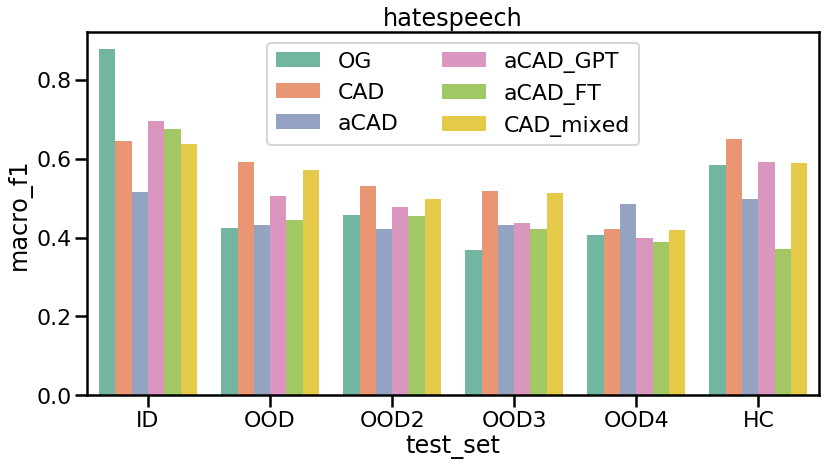

In [50]:
import seaborn as sns
import matplotlib as mpl 

sns.set_context('poster')

fig, ax = plt.subplots(figsize = (12, 7))
sns.barplot(data = all_results_df, x = 'test_set', y = 'macro_f1', #join = False,
             hue = 'mode', palette="Set2", # markers = True,#, hue_norm=mpl.colors.LogNorm()
            ax = ax)
title = construct
ax.set_title(title)
plt.legend(ncol=2)
plt.savefig('../results/figures/svm_%s.pdf' %title)
plt.tight_layout()
plt.show()

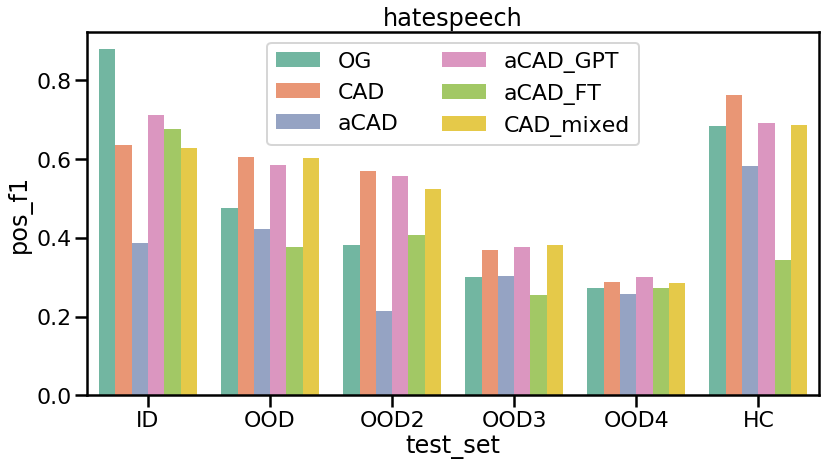

In [51]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.barplot(data = all_results_df, x = 'test_set', y = 'pos_f1', #join = False,
             hue = 'mode', palette="Set2", # markers = True,#, hue_norm=mpl.colors.LogNorm()
            ax = ax)
title = construct
ax.set_title(title)
plt.legend(ncol=2)
# plt.savefig('../results/figures/svm_%s.pdf' %title)
plt.tight_layout()
plt.show()

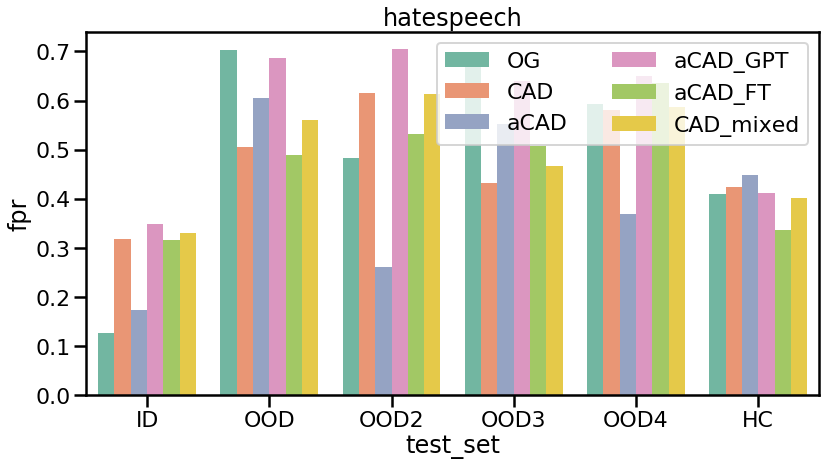

In [52]:
fig, ax = plt.subplots(figsize = (12, 7))
sns.barplot(data = all_results_df, x = 'test_set', y = 'fpr', #join = False,
             hue = 'mode', palette="Set2", # markers = True,#, hue_norm=mpl.colors.LogNorm()
            ax = ax)
title = construct
ax.set_title(title)
plt.legend(ncol=2)
# plt.savefig('../results/figures/svm_%s.pdf' %title)
plt.tight_layout()
plt.show()